In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy.linalg as la
from matplotlib import pyplot as mp
import math

def plotCurrent(X, Rnk, Kmus):
    N, D = X.shape
    K = Kmus.shape[0]

    InitColorMat = np.array([[1, 0, 0],
                             [0, 1, 0],
                             [0, 0, 1],
                             [0, 0, 0],
                             [1, 1, 0],
                             [1, 0, 1],
                             [0, 1, 1]])

    KColorMat = InitColorMat[0:K,:]

    colorVec = np.dot(Rnk, KColorMat)
    muColorVec = np.dot(np.eye(K), KColorMat)
    plt.scatter(X[:,0], X[:,1], c=colorVec)

    plt.scatter(Kmus[:,0], Kmus[:,1], s=200, c=muColorVec, marker='d')
    plt.axis('equal')
    plt.show()
    
X = np.loadtxt('scaledfaithful.txt')
N,D = X.shape

def calcSqDistances(X, Kmus):
    K = Kmus.shape[0]
    N = X.shape[0]
    sqDmatrix = np.zeros((N,K), dtype = np.float32)
    for i in range(N):
        for j in range(K):
            sqDmatrix[i,j] = la.norm(X[i] - Kmus[j])
    return sqDmatrix
    
def determineRnk(sqDmat):
    K = sqDmat.shape[1]
    N = sqDmat.shape[0]
    Rnk = np.zeros((N,K))
    length = len(sqDmat)
    for i in range(length):
        temp = np.argmin(sqDmat[i])
        Rnk[i][temp] = 1
    return Rnk
            
def recalcMus(X, Rnk):
    N = Rnk.shape[1]
    K = X.shape[1]
    Kmus = np.zeros((N,K))
    total_sum = np.sum(Rnk, axis = 0)
    return np.divide(X.T @ Rnk, total_sum).T
    
def runKMeans(fileString, K):
    X = np.loadtxt(fileString)
    N = np.shape(X)[0]
    D = np.shape(X)[1]
    Kmus = np.zeros((K, D))
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]
    maxiters = 1000
    for iter in range(maxiters):
        sqDmat = calcSqDistances(X, Kmus)
        Rnk = determineRnk(sqDmat)
        KmusOld = recalcMus(sqDmat,Rnk)
        Kmus = recalcMus(X, Rnk)
    plotCurrent(X, Rnk, Kmus)
    return Kmus

In [2]:
def gaussian(x, mu, sig):
        d = np.shape(x)[1]
        mu = mu[None, :]
        first = np.sqrt((2*math.pi)**(d) * np.linalg.det(sig))
        second = (np.exp(-np.diag((x - mu)@(np.linalg.inv(sig))@((x-mu).T)/2)))
        return (1/first) * second
    
def calcRespons(X, cov, pi, mu):
        N = X.shape[0]
        num = np.zeros((N, 2))
        for i in range(2):
            num[:,i] = pi[i] * gaussian(X, mu[i], np.diag(cov[i]))
        denom = np.sum(num, axis = 1, keepdims = True)
        return num / denom

In [5]:
class MixtureOfGaussians():
    def __init__(self, X, K, filestring):
        self.X = X
        self.D = self.X.shape[1]
        self.num_clusters = K
        self.mu = runKMeans(filestring, K)
        self.prior = np.asarray([1/K]* K)
        self.cov = np.zeros((K,self.D, self.D))
        for i in range(self.num_clusters):
            self.cov[i] = np.diag([1,2])
        print (self.cov)
        
    
    def train_EM(self, x, prior_old, mu_old, cov_old):
        for iters in (range(1000)):
            N = len(x)
            h = np.zeros((N, self.num_clusters), dtype = np.float32)
            for cluster in range(self.num_clusters):
                h[:,cluster] = self.gaussian(x, mu_old[cluster], cov_old[cluster] * prior_old[cluster])
            h = np.divide(h, np.sum(h, axis = 1, keepdims = True))
            prior_new = np.sum(h, axis = 0)
            
            mu_new = np.divide(h.T @ x, np.sum(h, axis=0, keepdims = True).T)
            cov_temp = np.zeros((self.num_clusters, self.D))
            
            for cluster in range(self.num_clusters):
                cov_temp[cluster] = np.divide(h[:, cluster].T@ ((x - mu_new[cluster])*((x - mu_new[cluster]))),np.sum(h[:,cluster]))
            cov_new = np.zeros((self.num_clusters, self.D, self.D))
            for i in range(self.num_clusters):
                cov_new[i] = np.diag(cov_temp[i])
            if np.linalg.norm(mu_new - mu_old) < 1e-3:
                break
            prior_old, mu_old, cov_old = prior_new, mu_new, cov_new
        return prior_new, mu_new, cov_new
    
    def get_parameters(self):
        prior_1, mu_1, cov_1 = self.train_EM(self.X, self.prior, self.mu, self.cov)
        params = [mu_1, cov_1, prior_1]
        return params
    
def plotWithRelation(data, gamma):
    length = len(X)
    for i in range(length):
        plt.plot(X[i,0],X[i,1], color=(gamma[i,0], 0, gamma[i,1]), marker='o', linestyle='none')
    plt.show()
    
def runGMM(K, fileString, pi_old, mu_old, var_old):
    X = np.loadtxt(fileString)
    N = np.shape(X)[0]
    D = np.shape(X)[1]
    maxiters = 1000
    for iter in range(maxiters):
        gamma = np.zeros((N, K))
        gamma = calcRespons(X, var_old, pi_old, mu_old)
        
        pi_new = np.sum(gamma, axis = 0) * (1/N)

        mu_k = np.zeros((K,D))
        for i in range(K):
            mu_k[i] = np.divide((gamma.T @ X)[i], np.sum(gamma[:,i]))

        var = np.zeros((K,D))
        for i in range(K):
            var[i] = np.divide((gamma[:,i].T @ ((X - mu_k[i])** 2)), np.sum(gamma[:,i]))
            var[var < .01] = .01

            if np.sum(np.abs(mu_old.reshape((-1,1)) - mu_k.reshape((-1,1)))) < 1e-2:
                break

        var_old, pi_old, mu_old = var, pi_new, mu_k
    plotWithRelation(X,gamma)
    return pi_old, mu_old, var_old


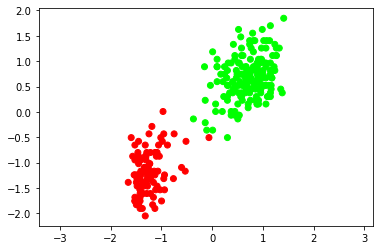

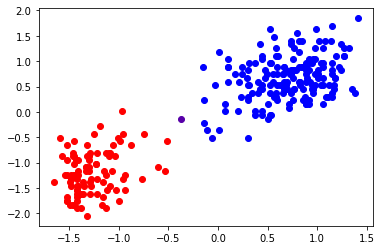

In [6]:
K=2
var = np.zeros((K,2))
pi_old = np.asarray([1/2] * 2)
mu_old = runKMeans('scaledfaithful.txt',K)
var_length = len(var)
for iteration in range(var_length):
    var[iteration] = np.asarray([2,3])
    
pi_new, mu_new, var_new = runGMM(K, 'scaledfaithful.txt', pi_old, mu_old, var)

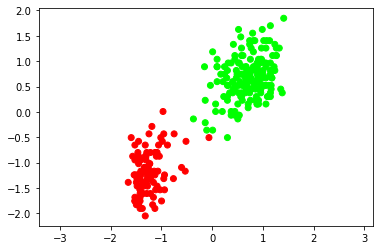

[[[1. 0.]
  [0. 2.]]

 [[1. 0.]
  [0. 2.]]]


In [7]:
X = np.loadtxt('scaledfaithful.txt')
GMM = MixtureOfGaussians(X, K=2, filestring='scaledfaithful.txt')